In [1]:
## Import Libraries
from __future__ import print_function
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
#Seed for Recreation of Results. Determining Randomness
random_seed = random.randint(0,10000)
print("Random Seed : ", random_seed)
random.seed(random_seed)
torch.manual_seed(random_seed)

Random Seed :  9712


In [3]:
#Arguments 
data = '/home/shubhansh/Work/Datasets/celebA/img_align_celeba'
workers = 4
batch_size = 128
img_size = 64
n_channel = 3
n_z = 100
n_fpg = 64
n_fpd = 64
n_epochs = 5
lr = 0.0002
beta1 = 0.5
ngpu = 1
device = torch.device("cuda:0")

In [4]:
#  Data Loader with resize,crop and Normalization
dataset  = dset.ImageFolder(root = data,transform = transforms.Compose([transforms.Resize(img_size),transforms.CenterCrop(img_size),transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]))

dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True,num_workers=workers)



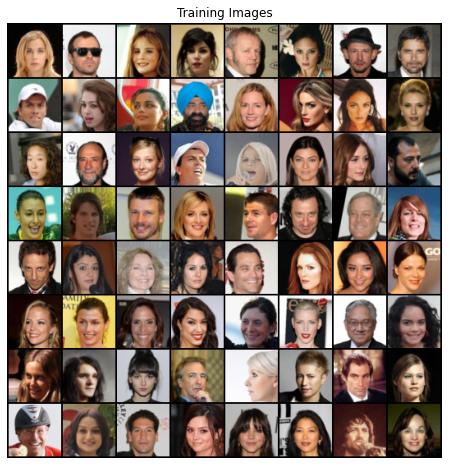

In [5]:
#Sample Batch for Visualization
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64],padding=2,normalize=True).cpu(),(1,2,0)))

In [6]:
# Weight Initialization for All networks(as per paper)
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv')!=-1:
        nn.init.normal_(m.weight.data,0.0,0.02)
    elif classname.find('BatchNorm')!=-1:
        nn.init.normal_(m.weight.data,1.0,0.02)
        nn.init.constant_(m.bias.data,0)

In [12]:
## Generator Architecture
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.convt1 = nn.ConvTranspose2d(n_z,n_fpg*8,4,1,0,bias = False)
        self.bn1 = nn.BatchNorm2d(n_fpg*8)

        self.convt2 = nn.ConvTranspose2d(n_fpg*8,n_fpg*4,4,2,1,bias = False)
        self.bn2 = nn.BatchNorm2d(n_fpg*4)

        self.convt3 = nn.ConvTranspose2d(n_fpg*4,n_fpg*2,4,2,1,bias = False)
        self.bn3 = nn.BatchNorm2d(n_fpg*2)

        self.convt4 = nn.ConvTranspose2d(n_fpg*2,n_fpg,4,2,1,bias = False)
        self.bn4 = nn.BatchNorm2d(n_fpg)

        self.convt5 = nn.ConvTranspose2d( n_fpg, n_channel, 4, 2, 1, bias=False)

    
    def forward(self,input):

        o1_1 = self.convt1(input)
        o1_2 = self.bn1(o1_1)
        o1_3 = F.relu(o1_2)

        o2_1 = self.convt2(o1_3)
        o2_2 = self.bn2(o2_1)
        o2_3 = F.relu(o2_2)

        o3_1 = self.convt3(o2_3)
        o3_2 = self.bn3(o3_1)
        o3_3 = F.relu(o3_2)

        o4_1 = self.convt4(o3_3)
        o4_2 = self.bn4(o4_1)
        o4_3 = F.relu(o4_2)

        output = F.tanh(self.convt5(o4_3))

        return output
        

    def layer_output_shape(self):

        with torch.no_grad():
            dummy = torch.zeros([1,n_z,1,1])
            print(dummy.shape)
            dummy = self.convt1(dummy)
            print(dummy.shape)
            dummy = self.bn1(dummy)
            print(dummy.shape)
            dummy = F.relu(dummy)
            print(dummy.shape)
            print("---------------")
            
            dummy = self.convt2(dummy)
            print(dummy.shape)
            dummy = self.bn2(dummy)
            print(dummy.shape)
            dummy = F.relu(dummy)
            print(dummy.shape)
            print("---------------")

            dummy = self.convt3(dummy)
            print(dummy.shape)
            dummy = self.bn3(dummy)
            print(dummy.shape)
            dummy = F.relu(dummy)
            print(dummy.shape)
            print("---------------")

            dummy = self.convt4(dummy)
            print(dummy.shape)
            dummy = self.bn4(dummy)
            print(dummy.shape)
            dummy = F.relu(dummy)
            print(dummy.shape)
            print("---------------")

            dummy = F.tanh(self.convt5(dummy))
            print(dummy.shape)
            print("---------------")
            del dummy


In [13]:
# Generator to GPU
netG = Generator().to(device)
# Initialization of Weights of Generator
netG.apply(weights_init)

Generator(
  (convt1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convt2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convt3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convt4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convt5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)

In [9]:
## Discriminator Architecture
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.conv1 = nn.Conv2d(n_channel,n_fpd,4,2,1,bias = False)
        self.bn1 = nn.BatchNorm2d(n_fpd)

        self.conv2 = nn.Conv2d(n_fpd,n_fpd*2,4,2,1,bias = False)
        self.bn2 = nn.BatchNorm2d(n_fpd*2)

        self.conv3 = nn.Conv2d(n_fpd*2,n_fpd*4,4,2,1,bias = False)
        self.bn3 = nn.BatchNorm2d(n_fpd*4)

        self.conv4 = nn.Conv2d(n_fpd*4,n_fpd*8,4,2,1,bias = False)
        self.bn4 = nn.BatchNorm2d(n_fpg*8)

        self.conv5 = nn.Conv2d( n_fpd*8, 1, 4, 1, 0, bias=False)
    
    def forward(self,input):

        o1_1 = self.conv1(input)
        o1_2 = self.bn1(o1_1)
        o1_3 = F.leaky_relu(o1_2,0.2)

        o2_1 = self.conv2(o1_3)
        o2_2 = self.bn2(o2_1)
        o2_3 = F.leaky_relu(o2_2,0.2)

        o3_1 = self.conv3(o2_3)
        o3_2 = self.bn3(o3_1)
        o3_3 = F.leaky_relu(o3_2,0.2)

        o4_1 = self.conv4(o3_3)
        o4_2 = self.bn4(o4_1)
        o4_3 = F.leaky_relu(o4_2,0.2)

        output = F.sigmoid(self.conv5(o4_3))

        return output
    
    def layer_output_shape(self,h,w=None):
        if w==None:
            w=h
        with torch.no_grad():
            dummy = torch.zeros([1,n_channel,h,w],device=device)
            print(dummy.shape)
            dummy = self.conv1(dummy)
            print(dummy.shape)
            dummy = self.bn1(dummy)
            print(dummy.shape)
            dummy = F.leaky_relu(dummy,0.2)
            print(dummy.shape)
            print("---------------")
            

            dummy = self.conv2(dummy)
            print(dummy.shape)
            dummy = self.bn2(dummy)
            print(dummy.shape)
            dummy = F.leaky_relu(dummy,0.2)
            print(dummy.shape)
            print("---------------")

            dummy = self.conv3(dummy)
            print(dummy.shape)
            dummy = self.bn3(dummy)
            print(dummy.shape)
            dummy = F.leaky_relu(dummy,0.2)
            print(dummy.shape)
            print("---------------")

            dummy = self.conv4(dummy)
            print(dummy.shape)
            dummy = self.bn4(dummy)
            print(dummy.shape)
            dummy = F.leaky_relu(dummy,0.2)
            print(dummy.shape)
            print("---------------")

            output = F.sigmoid(self.conv5(dummy))
            print(dummy.shape)
            print("---------------")
            del dummy
    


In [14]:
netG.layer_output_shape()

torch.Size([1, 100, 1, 1])


RuntimeError: Tensor for argument #1 'input' is on CPU, Tensor for argument #2 'output' is on CPU, but expected them to be on GPU (while checking arguments for slow_conv_transpose2d_out_cuda)

In [11]:
# Discriminator to GPU
netD = Discriminator().to(device)
# Discriminator Weight Initialization
netD.apply(weights_init)

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
)

In [12]:
## Binary Cross Entropy Loss
criterion = nn.BCELoss()

##For Results
fixed_batch = torch.randn(64,n_z,1,1,device=device)
## Assign 1 to Real Images
real_label = 1
## Assign 0 to Fake Images
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [13]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

In [17]:
print("Starting Training .....")
for epoch in range(n_epochs):
    for i,data in enumerate(dataloader,0):

        ### Discriminator Update

        ## Making Zero Gradient in Start(Remove residual gradient from previous epoch)
        netD.zero_grad()


        ## Passing Real Batch
        real_data = data[0].to(device)
        b_size = real_data.shape[0]
        label = torch.full((b_size,),real_label,device=device)
        output = netD(real_data).view(-1)
        netD_error_real = criterion(output,label)
        ##compute gradient
        netD_error_real.backward()
        ## Average output as it will tell how good out Discriminator is. This value should approach to 1.
        D_real = output.mean().item()

        ## Generate fake images using generator

        noise = torch.randn(b_size,n_z,1,1,device= device)
        fake_data = netG(noise)
        label.fill_(fake_label)

        ## Passing Fake Batches

        output = netD(fake_data.detach()).view(-1)
        netD_error_fake = criterion(output,label)
        ##compute gradient (Gradient is additive so network have aggregated gradient values)
        netD_error_fake.backward()
        ## Average output as it will tell how good out Discriminator is. This value should approach to 0.
        D_fake = output.mean().item()

        ## Total Discriminator Error
        netD_error = netD_error_fake + netD_error_real

        ## Update the Discriminator
        optimizerD.step()


        ### Generator Update
        
        ## Making Zero Gradient in Start(Remove residual gradient from previous epoch)
        netG.zero_grad()

        output = netD(fake_data).view(-1)
        ## Generator want label to be 1, so error will be considered when discriminator will assign  generated images a non zero value.
        label.fill_(real_label)
        netG_error = criterion(output,label)
        netG_error.backward()
        DG_fake = output.mean().item()

        ## Update the Generator
        optimizerG.step()

        if i%50==0:
            print("[%d/%d],[%d/%d]\t Loss_D: %0.4f\t Loss_G: %0.4f\t Avg_D_real: %0.4f\t Avg_D/DG: [%0.4f/%0.4f]" % (epoch,n_epochs,i,len(dataloader),netD_error.item(),netG_error.item(),D_real,D_fake,DG_fake))


        G_losses.append(netG_error.item())
        D_losses.append(netD_error.item())

        if(iters%500==0) or ((epoch==n_epochs-1)and(i==len(dataloader)-1)):
            with torch.no_grad():
                fake_img = netG(fixed_batch).detach().cpu()
            img_list.append(vutils.make_grid(fake_img,padding=2,normalize=True))

        iters+=1








Starting Training .....


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [128]] is at version 1; expected version 0 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

In [13]:
netG.summary

AttributeError: 'Generator' object has no attribute 'summary'